## LINMA1702 - Projet
# Utilisation optimale d'une pompe à chaleur domestique

###  Notebook pour le rapport final - version 2.1
### Numéro du groupe : 5
### Membres du groupe : Janssen Tom, L'Hermite Dumont Issambre, Nouidei Safiya, Orékhoff Alexandre

## Description générale

Une pompe à chaleur permet de chauffer un bâtiment en consommant moins d'énergie qu'au chauffage électrique classique, grâce à un coefficient de performance (COP) supérieur à un. Elle peut également fonctionner de façon réversible, c'est-à-dire qu'elle permet de refroidir en été.

Dans ce projet, on va utiliser une pompe à chaleur pour maintenir le température intérieur d'un bâtiment dans une plage confortable, tout en minimisant le coût de l'électricité consommée.

### Hypothèses et données
- On considère une année entière, qu'on discrétise par intervalles de temps d'une durée de 15 minutes
- Le bâtiment est situé à Montréal, et on dispose de la température extérieure durant chaque intervalle de temps 
- On suppose que la température du bâtiment est homogène, et on s'intéressera uniquement à la valeur qu'elle prend toutes les 15 minutes (on ne s'intéresse donc pas à la dynamique de la température au cours d'un intervalle de temps)
- Durant chaque intervalle de temps la température intérieure évolue en fonction la température externe : la différence de température entre le début et la fin d'un intervalle de temps est proportionnel à la différence entre la température externe et la température interne (le coefficient de proportionnalité dépendant de l'isolation du bâtiment)
- Pendant chaque intervalle de temps on peut choisir d'activer la pompe à chaleur. Plus précisément, on peut décider de la puissance qu'on va utiliser pour la pompe à chaleur, jusqu'à une certaine puissance maximale. Celle-ci va alors prélever de la chaleur extérieure et la transférer à l'intérieur du bâtiment (ou l'inverse si on décide de fonctionne en mode refroidissement, nommé "reverse"). La quantité de chaleur transférée est proportionnelle à la puissance électrique consommée, mais aussi au coefficient de performance (COP).
- La variation de la température du bâtiment causée par l'activation de la pompe à chaleur est proportionnelle à la chaleur/énergie transférée
- Le coefficient de performance de la pompe à chaleur est supposé dépendre uniquement de la température extérieure et du mode de fonctionnement, normal ou reverse.
- Le coût unitaire de l'électricité consommée dépend de l'heure où elle est prélevée (tarif bi-horaire)
   
### Remarque à propos de la modélisation
En général, quand on modélise un problème, on décide d'effectuer certaines hypothèses et/ou approximations. Il y a certainement plusieurs façons tout à fait valides de modéliser le problème, donc pas pas forcément une unique bonne réponse. Vous pouvez interpréter l'énoncé de la façon qui vous convient le mieux du moment qu'elle reste raisonnable. 
(par exemple : l'énoncé suggère de ne pas analyser/de prendre en compte ce qui se passe à l'intérieur d'un intervalle de temps, ce qui est un choix ; aussi : le fonctionnement simultané en mode chauffage et reverse pourrait être a priori permis ou interdit, mais cela change-t-il vraiment les choses ?)

## Tâches

**Tâche 1** : on souhaite dans un premier temps que la température du bâtiment reste comprise dans une certaine plage admissible de températures, et on cherche à **minimiser le coût total de l'électricité consommée par la pompe à chaleur**. Formulez ce problème comme un problème d'optimisation linéaire, puis résolvez le.

Pour des raisons de temps de calcul, votre modèle considérera uniquement une période de 7 jours consécutifs. Il fera l'hypothèse que la température initiale au début de la période est égale à la valeur centrale de la plage admissible, et fera en sorte que la température finale à la fin de la période revienne à la même valeur. Votre code prendra donc en entrée un paramètre indiquant le numéro de l'intervalle de temps qui début la période, qui s'étendra sur $7 \times 24 \times 4 = 672$ intervalles de temps.

<div class="alert alert-block alert-warning"><b>A mentionner</b> :<br> 
- coût minimal + graphique de l'évolution des températures + graphique représentant l'utilisation de la pompe à chaleur (en distinguant le fonctionnement normal du fonctionnement _reverse_) + temps de calcul + bref commentaire (maximum 4 lignes)<br>
- pour deux périodes distinctes (placer les résultats côté à côté) : à gauche une période pré-déterminée (cf. fichier de données), et à droite une seconde période que vous choisirez en fonction de son intérêt
</div>

---

Import et initialisation des valeurs basiques.

In [150]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [151]:
temperatures_montreal = np.load("Temperatures-Montreal.npy")
eta = 0.99
max_pump_power = 1 # kW
Cp = 0.4 # °C/1kWh
T_min = 19 # °C
T_max = 21 # °C
inconfort_penality_supp = 1
inconfort_penality_inf = 3
ref_week_start_idx = 13050 # mi-avril 
arbitrary_week_start_idx = 18300 # début juin (arbitrary)
computing_intervals_amount = 7*24*4 
task_3_step = 2 # arbitrary
mid_temperature = (T_max + T_min)//2  
task_2_budget_coefficient = 0.75 # arbitrary

# Initialisation du tarif bi-horaire pour les couts d'éléctricité
electricity_cost = [0.18 if (i % (24*4)) /4 >= 22 or (i % (24*4))/4 < 7 else 0.26 for i in range(len(temperatures_montreal))] 

# Fonction qui renvoie la COP de chauffe
def COP_warming(T_ext):
    return 3 + 10 * abs(np.tanh(T_ext/100)) * np.tanh(T_ext/100)

# Fonction qui renvoie la COP de refroidissement
def COP_reverse():
    return 3.2

<div class="alert alert-block alert-info"><b>Question 1.1</b> :<br> 
    Donnez votre formulation linéaire, en commentant brièvement (en particulier si vous utilisez une technique de modélisation/reformulation).
</div>

In [152]:
# Fonction qui renvoie la chaleur perdue sans action de la pompe
def next_temperature(T_old, T_ext):
    return - (1-eta) * (T_old - T_ext) + T_old

# Fonction qui effectue la tache 1 et 2 (pour passer a la tache 2, il faut définir max_cost):
def basic(first_interval_idx, max_cost=math.inf):
    inconfort_mode = max_cost != math.inf                                               # Mode inconfort pour faire la tache 1 ou 2 (False ou True)
    # Séléction des intervalles dans toutes les données
    last_interval_idx = first_interval_idx + computing_intervals_amount                                 
    temperatures_ext = temperatures_montreal[first_interval_idx:last_interval_idx]

    p_warming = cp.Variable(computing_intervals_amount, nonneg=True)                    # Puissance de la pompe à l'intervalle i en réchauffement
    p_reverse = cp.Variable(computing_intervals_amount, nonneg=True)                    # Puissance de la pompe à l'intervalle i en reverse
    temperatures_int = cp.Variable(computing_intervals_amount)                          # Températures intérieures
    partial_electricity_cost = electricity_cost[first_interval_idx:last_interval_idx]   # Coût de l'électricité sur la période sélectionnée
    
    cost = cp.sum(partial_electricity_cost @ (p_warming + p_reverse))                   # Somme qui décrit le cout en $ du fonctionnement de la pompe

    # Initialisation des contraintes sur les puissances
    constraints = [p_warming >= 0]                 # Minimum 
    constraints += [p_reverse >= 0]                # Minimum
    constraints += [p_warming <= max_pump_power]   # Maximum
    constraints += [p_reverse <= max_pump_power]   # Maximum

    # Initialisation des contraintes sur les températures
    constraints += [temperatures_int[0] == mid_temperature]                                                # Température de début
    constraints += [temperatures_int[-1] == mid_temperature]                                               # Température de fin

    # Initialisation des contraintes de relations entre les températures i et i+1
    constraints += [temperatures_int[1:] == next_temperature(temperatures_int[:-1], temperatures_ext[:-1]) # Perte de chaleur sans action
    + cp.multiply(COP_warming(temperatures_ext[:-1]), p_warming[:-1])  * Cp                                # Chauffe en mode normal
    - cp.multiply(COP_reverse(), p_reverse[:-1])  * Cp                                                     # Refroidissement en mode reverse
    ]

    # Si le mode inconfort est True alors on fait la tache 2 
    if inconfort_mode:
        inconforts_sup = cp.Variable(computing_intervals_amount, nonneg=True)                              # Inconfort au dessus de la température max à l'intervalle i
        inconforts_inf = cp.Variable(computing_intervals_amount, nonneg=True)                              # Inconfort en dessous de la température min à l'intervalle i
        objective = cp.sum(inconforts_sup*inconfort_penality_supp + inconfort_penality_inf*inconforts_inf) # Fonction objectif qui représente l'inconfort et doit etre minimisé
        constraints += [cost <= max_cost]                                                                  # La somme du cout devient une contrainte
        constraints += [temperatures_int - T_min >= -inconforts_inf]                                       # Contrainte pour avoir les valeurs de l'inconfort inf
        constraints += [temperatures_int - T_max <= inconforts_sup]                                        # Contrainte pour avoir les valeurs de l'inconfort inf

    # Sinon on fait la tache 1
    else:
        constraints += [temperatures_int >= T_min]  # Contrainte sur la valeur minimum des températures
        constraints += [temperatures_int <= T_max]  # Contrainte sur la valeur maximum des températures
        objective = cost                            # La somme du cout devient l'objectif
     

    problem = cp.Problem(cp.Minimize(objective), constraints)                                                # Définit le probleme avec ses contraintes et son objectif a minimiser
    start_time = time.time()
    solution = problem.solve(solver=cp.SCIPY, scipy_options={"method": "highs"}, warm_start=inconfort_mode)  # Résoud le probleme avec HiGHS et si on fait la tache 2 utilise le mode warm_start
    end_time = time.time()

    # Renvoie les valeurs 
    if cost.value is None: 
        return []
    return [temperatures_int.value, p_warming.value, p_reverse.value, cost.value, problem.value, end_time - start_time]

Fonction pour le plot de la tache 1:

In [153]:
# Fonction qui plot la tache 1
def plot_1(period_1, period_2, period_1_first_interval_idx, period_2_first_interval_idx): 
    periods = [period_1, period_2]
    first_interval_idxs = [period_1_first_interval_idx, period_2_first_interval_idx]

    # Crée la figure
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 6))

    # Plot les graphes pour les 2 périodes
    for i in range(len(periods)):
        period = periods[i] 
        first_interval_idx = first_interval_idxs[i]
        last_interval_idx = first_interval_idx + computing_intervals_amount

        x = np.linspace(first_interval_idx, last_interval_idx, computing_intervals_amount)

        # Plot des températures
        axs[0][i].scatter(x, period[0], s=0.5)
        axs[0][i].set_title("Période {i} - Évolution des températures".format(i=i+1))
        axs[0][i].set_xlabel("Intervalle de temps")
        axs[0][i].set_ylabel("Température (°C)")

        # Plot des puissances
        axs[1][i].scatter(x, period[1], label="Fonctionnement normal", s=0.5)
        axs[1][i].scatter(x, period[2], label="Fonctionnement reverse", s=0.5)
        axs[1][i].set_title("Période {i} - Utilisation de la pompe à chaleur".format(i=i+1))
        axs[1][i].set_xlabel("Intervalle de temps")
        axs[1][i].set_ylabel("Puissance (kW)")
        axs[1][i].legend()
        print("1. Coût période {i} : {cost}".format(i=i+1, cost=period[3]))
        plt. gcf(). subplots_adjust( wspace = 0.7, hspace = 1) 

    fig.canvas.manager.set_window_title("Tâche 1 - Minimisation du coût avec T_min <= T <= T_max")
    plt.show()

<div class="alert alert-block alert-info"><b>Question 1.2</b> :<br> 
    Résolvez votre modèle sur les deux intervalles de temps, affichez vos résultats sous forme graphique et commentez.
</div>

Computed output_1_ref in 0.04996991157531738s
Computed output_1_arbitrary in 0.04036569595336914s
1. Coût période 1 : 8.096833459362273
1. Coût période 2 : 2.898588747736671


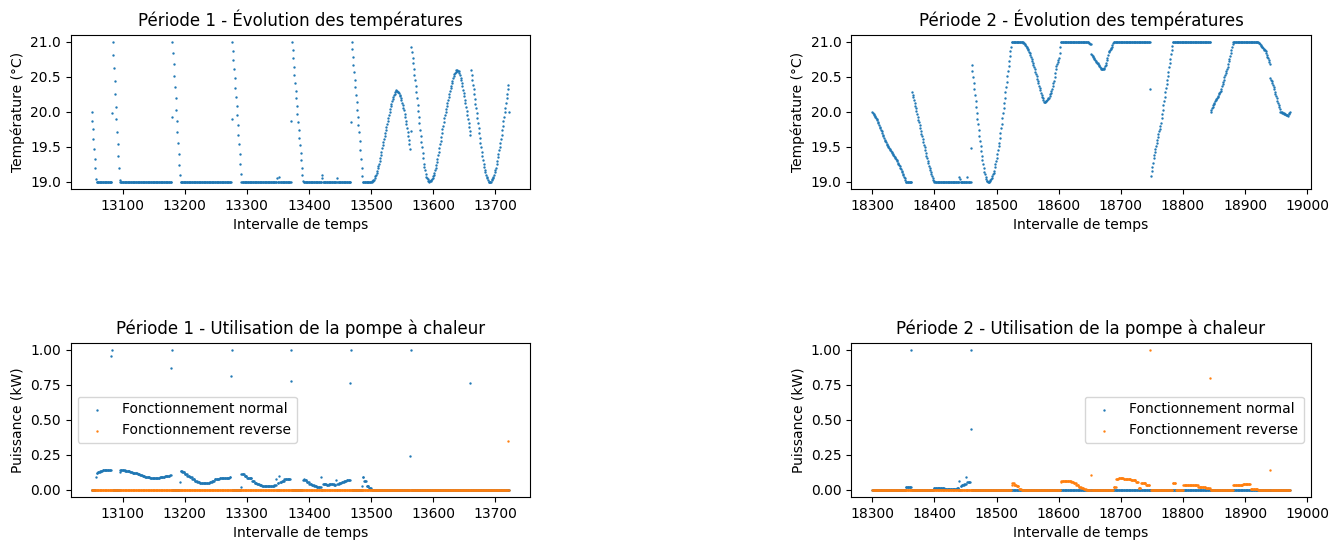

In [154]:
# Tache 1, période 1:
output_1_ref = basic(ref_week_start_idx)
print("Computed output_1_ref in {time}s".format(time=output_1_ref[-1]))

# Tache 1, période 2:
output_1_arbitrary = basic(arbitrary_week_start_idx)
print("Computed output_1_arbitrary in {time}s".format(time=output_1_arbitrary[-1]))

# Plot les résultats
plot_1(output_1_ref, output_1_arbitrary, ref_week_start_idx, arbitrary_week_start_idx) 

<div class="alert alert-block alert-info"><b>Question 1.3</b> :<br> 
    A partir de certaines informations fournies par le solver (et donc sans effectuer de nouveau calcul) et de la théorie vue au cours, prédisez l'effet sur le coût optimal d'une diminution de la tempéature minimale admissible Tmin. Faites de même pour une augmentation de la température maximale admissible Tmax. 
    Votre prédiction consiste en un formule pour le coût optimal en fonction des deux variations de température Tmin et Tmax. Commentez cette prédiction (en particulier : est-elle valide pour n'importe quelle variation des températures ?).
</div>

<b>Réponse 1.3 </b>:

Tout d'abord, augmenter $T_{max}$ revient à "relaxer" le problème initial. Il y aura un plus grand domaine admissible pour les solutions et donc on ne peut qu'améliorer la solution optimale (et donc diminuer le coût).

Dans un problème semblable au nôtre, de type:  min $ c^{T}x$ avec $A x= b$ et $x>= 0$, cela revient à modifier b en lui ajoutant un $ \Delta b$. Le coût optimal variera: $\Delta c* = (\Delta b)^{T} y^{*}$, avec $y^{*}$ la solution optimale du problème dual.

La condition de validité de la formule est $B^{-1} \tilde{b} >= 0$ ou encore $x^{*}_{b} + B^{-1} \Delta b >= 0$.

On observe la même chose lorsqu'on diminue $T_{min}$ puisqu'on augmente aussi le domaine admissible. Cependant, il conviendra de faire attention aux signes des inégalités, puisqu'évidemment diminuer $T_{min}$ ne revient pas à réduire l'espace admissible.

<div class="alert alert-block alert-info"><b>Question 1.4</b> :<br> 
   Démontrez que, dans toute solution optimale de ce modèle, l'activation simultanée du chauffage et du mode reverse durant la même période de temps est impossible.
</div>

<b> Réponse 1.4 </b> :

Supposons que ce soit possible d'activer le mode chauffage et le mode reverse en même temps. Cela signifierait que la pompe diminuerai la chaleur du bâtiment et l'augmenterai simultanément, ce qui est incoherent dans une optique de minimisation du cout puisqu'on utilise deux fois la pompe pour faire deux action qui s'annule

<font color="red"> Par conséquent, le COP serait inférieur à 1 ce qui ne correspond pas à ce qu'on cherche. </font> <font color="green"> <== jsp quoi en faire</font>

Pour prouver que l’activation simultanée des modes normal et reverse est impossible dans une solution optimale, regardons dans quel cas la pompe s'active. Dans une solution optimale, la pompe n’est utilisé que lorsqu’on sort presque de la plage de températures admissible. Supposons que nous utilisions les deux modes pendant la même période, cela signifierait qu’il y aurait un moment dans notre modèle actuel où la température intérieure serait inférieure à 19°C et simultanément supérieure à 21°C, ce qui est impossible. 


Dans ce scénario, la pompe devrait être utilisée plus fréquemment pour réchauffer et refroidir l’espace, ce qui entraînerait des coûts d’utilisation plus élevés. Puisqu’on cherche à minimiser le coût total de l’électricité consommée par la pompe à chaleur, un seul des 2 modes devra être utilisé. Si c’est le mode normal qui est utilisé, alors on réchauffera la pièce et puisqu’on cherche à minimiser le coût total, on ne devrait pas réchauffer la pièce assez que pour avoir besoin d’utiliser le mode reverse et inversement. Par ailleurs, la température à chaque intervalle dépend de la température à l’intervalle qui le précède (et de la température extérieure) et donc d’une certaine façon s’il y a l’activation de la pompe en mode reverse et en mode normal, c’est que ça a été demandé. Il est plutôt difficile de s’imaginer un scénario dans lequel on utiliserait ces 2 modes (à moins que la température de dehors varie vraiment fortement, ou que plusieurs contraintes soient introduites dans le modèle). Évidemment, dans un scénario idéal son utilisation serait nulle.

<div class="alert alert-block alert-info"><b>Question 1.5</b> :<br> 
    Modifiez votre modèle de façon à tenir compte des deux nouvelles contraintes suivantes :<br>
    - si la pompe à chaleur est utilisée (dans un mode ou dans l'autre), elle l'est au moins à 25% de sa puissance maximale. Il n'est donc plus possible d'utiliser la pompe à chaleur à très faible puissance.
<br>
    - si on décide d'allumer (ou d'éteindre) la pompe à chaleur, elle reste allumée (ou éteinte) sur une période de x heures consécutives. Ces périodes sont fixes : par exemple, si x=4h, il s'agit de [0h-4h], [4h-8h], [8h-12h], [12h-16h], etc. pour chaque journée.<br>
    Le nouveau modèle sera toujours obligatoirement linéaire, mais pourra faire appel à des variables discrètes. 
    Donnez votre formulation, et commentez brièvement.
</div>

In [ ]:
def Q1_5(first_interval_idx,x, max_cost=math.inf):
    inconfort_mode = max_cost != math.inf
    last_interval_idx = first_interval_idx + computing_intervals_amount                                 
    temperatures_ext = temperatures_montreal[first_interval_idx:last_interval_idx]

    p_warming = cp.Variable(computing_intervals_amount, nonneg=True)                                    # Puissance de la pompe à l'intervalle i en réchauffement
    p_reverse = cp.Variable(computing_intervals_amount, nonneg=True)                                    # Puissance de la pompe à l'intervalle i en reverse
    temperatures_int = cp.Variable(computing_intervals_amount)                                          # Températures intérieures
    partial_electricity_cost = electricity_cost[first_interval_idx:last_interval_idx]                   # Coût de l'électricité sur la période sélectionnée
    
    cost = cp.sum(partial_electricity_cost @ (p_warming + p_reverse))

    constraints = [p_warming >= 0]
    constraints += [p_reverse >= 0]
    constraints += [p_warming <= max_pump_power]
    constraints += [p_reverse <= max_pump_power]
    constraints += [temperatures_int[0] == mid_temperature]
    constraints += [temperatures_int[-1] == mid_temperature]
    constraints += [temperatures_int[1:] == next_temperature(temperatures_int[:-1], temperatures_ext[:-1]) 
    + cp.multiply(COP_warming(temperatures_ext[:-1]), p_warming[:-1]) * Cp 
    - cp.multiply(COP_reverse(), p_reverse[:-1]) * Cp
    ]

    if inconfort_mode:
        inconforts_sup = cp.Variable(computing_intervals_amount, nonneg=True)
        inconforts_inf = cp.Variable(computing_intervals_amount, nonneg=True)
        objective = cp.sum(inconforts_sup*inconfort_penality_supp + inconfort_penality_inf*inconforts_inf)
        constraints += [cost <= max_cost]
        constraints += [temperatures_int - T_min >= -inconforts_inf]
        constraints += [temperatures_int - T_max <= inconforts_sup]
    else:
        constraints += [temperatures_int >= T_min]
        constraints += [temperatures_int <= T_max]
        objective = cost 
        b1 = cp.Variable(computing_intervals_amount, boolean=True)
        b2 = cp.Variable(computing_intervals_amount, boolean=True)

        constraints += [b1 * 0.25 *max_pump_power <= p_warming]
        constraints += [p_warming <= b1 * max_pump_power]
        constraints += [b2 * 0.25 *max_pump_power <= p_reverse]
        constraints += [p_reverse <= b2 * max_pump_power]

        for i in range(0,computing_intervals_amount,4*x):
            for j in range(4*x):
                constraints += [b1[i+j] == b1[i]]
                constraints += [b2[i+j] == b2[i]]
        

    

    problem = cp.Problem(cp.Minimize(objective), constraints)
    start_time = time.time()
    solution = problem.solve(solver=cp.SCIPY, scipy_options={"method": "highs"}, warm_start=inconfort_mode)
    end_time = time.time()

    if cost.value is None: 
        print("None")
        return []
    output = [temperatures_int.value, p_warming.value, p_reverse.value, cost.value, problem.value, end_time - start_time]
    #print(output)
    return output

Fonction pour le plot de la question 1.5:

In [ ]:
# Fonction qui plot la tache 1
def plot_1(period_1, period_2, period_1_first_interval_idx, period_2_first_interval_idx): 
    periods = [period_1, period_2]
    first_interval_idxs = [period_1_first_interval_idx, period_2_first_interval_idx]

    # Crée la figure
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 6))

    # Plot les graphes pour les 2 périodes
    for i in range(len(periods)):
        period = periods[i] 
        first_interval_idx = first_interval_idxs[i]
        last_interval_idx = first_interval_idx + computing_intervals_amount

        x = np.linspace(first_interval_idx, last_interval_idx, computing_intervals_amount)

        # Plot des températures
        axs[0][i].scatter(x, period[0], s=0.5)
        axs[0][i].set_title("Période {i} - Évolution des températures".format(i=i+1))
        axs[0][i].set_xlabel("Intervalle de temps")
        axs[0][i].set_ylabel("Température (°C)")

        # Plot des puissances
        axs[1][i].scatter(x, period[1], label="Fonctionnement normal", s=0.5)
        axs[1][i].scatter(x, period[2], label="Fonctionnement reverse", s=0.5)
        axs[1][i].set_title("Période {i} - Utilisation de la pompe à chaleur".format(i=i+1))
        axs[1][i].set_xlabel("Intervalle de temps")
        axs[1][i].set_ylabel("Puissance (kW)")
        axs[1][i].legend()
        print("1. Coût période {i} : {cost}".format(i=i+1, cost=period[3]))
        plt. gcf(). subplots_adjust( wspace = 0.7, hspace = 1) 

    fig.canvas.manager.set_window_title("Tâche 1 - Minimisation du coût avec T_min <= T <= T_max")
    plt.show()

<div class="alert alert-block alert-info"><b>Question 1.6</b> :<br> 
    Résolvez ce nouveau modèle, affichez les résultats et commentez (en particulier le temps de calcul). Choissisez d'abord une valeur x=4h, puis x=2h.
</div>

<div class="alert alert-block alert-info"><b>Question 1.7</b> :<br> 
    Décrivez comment on pourrait apporter les modifications suivantes au nouveau modèle de la Question 1.5, sans les implémenter : <br>
    (a) tenir compte d'un coût fixe supplémentaire à payer pour chaque intervalle de temps où la pompe à chaleur est utilisée<br>
    (b) empêcher le nombre total d'allumages de la pompe à chaleur à ne pas dépasser une certaine valeur maximale (un allumage = passage de l'état 'éteint' lors d'un invervalle de temps à l'état 'allumé' lors de l'intervalle de temps suivant)<br>
    (c) dans ce nouveau modèle il n'est plus nécessairement impossible d'observer dans une solution optimale l'activation simultanée du chauffage et du mode reverse au cours du même intervalle de temps : expliquez pourquoi, et proposez une contrainte permettant d'éliminer cette possibilité d'activation simultanée.
</div>

<b> Réponse 1.7 </b> :

(a) On pourrait introduire une variable binaire $x_{i}$ qui vaudrait 1 si on utilise la pompe à chaleur dans l'intervalle $i$ et 0 sinon. On ajouterait au coût à minimiser $ \sum_{i} x_{i}* c_{f}$ avec $c_{f}$ les côuts fixes.

(b) On pourrait réintroduire le même type de variable binaire qu'au point (a) et imposer que $\sum_{i} x_{i} $ soit minimiser au travers d'un cout fixe par allumage comme au point (a) par exemple. Cependant, il faut d'abord vérifier que la pompe était éteinte à l'intervalle précedent. Si elle était déjà allumée, la variable reste à 0.

**Tâche 2** : on souhaite réduire le coût d'utilisation de la pompe à chaleur, et on va fixer le budget maximal à une certaine proportion du coût minimal identifié lors de la première tâche. Pour diminuer les coût, on va permettre aux températures de sortir de la plage admissible définie plus haut (on abandonne aussi la contrainte sur la température finale, qui devient libre). On va cependant alors comptabiliser la quantité d'_inconfort_ éventuellement subi durant chaque intervalle de temps, qui sera proportionnel au dépassement de la température maximale admissible, ou au dépassement par le bas de la température minimale admissible. On cherche alors à **minimiser l'inconfort total** (somme des inconforts sur toute la période considérée) **tout en respectant la contrainte de budget**. Formulez ce problème comme un problème d'optimisation linéaire, puis résolvez le.


<div class="alert alert-block alert-warning"><b>A mentionner</b> :<br> 
- inconfort minimal + même graphiques que pour tâche 1 + temps de calcul + bref commentaire (maximum 4 lignes)<br>
- à nouveau pour les deux périodes mentionnées lors de la tâche 1
</div>

---

<div class="alert alert-block alert-info"><b>Question 2.1</b> :<br> 
    Donnez votre formulation linéaire, en commentant brièvement (en particulier si vous utilisez une technique de modélisation/reformulation).
</div>

In [155]:
# Fonction qui renvoie la chaleur perdue sans action de la pompe
def next_temperature(T_old, T_ext):
    return - (1-eta) * (T_old - T_ext) + T_old

# Fonction qui effectue la tache 1 et 2 (pour passer a la tache 2, il faut définir max_cost):
def basic(first_interval_idx, max_cost=math.inf):
    inconfort_mode = max_cost != math.inf                                               # Mode inconfort pour faire la tache 1 ou 2 (False ou True)
    # Séléction des intervalles dans toutes les données
    last_interval_idx = first_interval_idx + computing_intervals_amount                                 
    temperatures_ext = temperatures_montreal[first_interval_idx:last_interval_idx]

    p_warming = cp.Variable(computing_intervals_amount, nonneg=True)                    # Puissance de la pompe à l'intervalle i en réchauffement
    p_reverse = cp.Variable(computing_intervals_amount, nonneg=True)                    # Puissance de la pompe à l'intervalle i en reverse
    temperatures_int = cp.Variable(computing_intervals_amount)                          # Températures intérieures
    partial_electricity_cost = electricity_cost[first_interval_idx:last_interval_idx]   # Coût de l'électricité sur la période sélectionnée
    
    cost = cp.sum(partial_electricity_cost @ (p_warming + p_reverse))                   # Somme qui décrit le cout en $ du fonctionnement de la pompe

    # Initialisation des contraintes sur les puissances
    constraints = [p_warming >= 0]                 # Minimum 
    constraints += [p_reverse >= 0]                # Minimum
    constraints += [p_warming <= max_pump_power]   # Maximum
    constraints += [p_reverse <= max_pump_power]   # Maximum

    # Initialisation des contraintes sur les températures
    constraints += [temperatures_int[0] == mid_temperature]                                                # Température de début
    constraints += [temperatures_int[-1] == mid_temperature]                                               # Température de fin

    # Initialisation des contraintes de relations entre les températures i et i+1
    constraints += [temperatures_int[1:] == next_temperature(temperatures_int[:-1], temperatures_ext[:-1]) # Perte de chaleur sans action
    + cp.multiply(COP_warming(temperatures_ext[:-1]), p_warming[:-1])  * Cp                                # Chauffe en mode normal
    - cp.multiply(COP_reverse(), p_reverse[:-1])  * Cp                                                     # Refroidissement en mode reverse
    ]

    # Si le mode inconfort est True alors on fait la tache 2 
    if inconfort_mode:
        inconforts_sup = cp.Variable(computing_intervals_amount, nonneg=True)                              # Inconfort au dessus de la température max à l'intervalle i
        inconforts_inf = cp.Variable(computing_intervals_amount, nonneg=True)                              # Inconfort en dessous de la température min à l'intervalle i
        objective = cp.sum(inconforts_sup*inconfort_penality_supp + inconfort_penality_inf*inconforts_inf) # Fonction objectif qui représente l'inconfort et doit etre minimisé
        constraints += [cost <= max_cost]                                                                  # La somme du cout devient une contrainte
        constraints += [temperatures_int - T_min >= -inconforts_inf]                                       # Contrainte pour avoir les valeurs de l'inconfort inf
        constraints += [temperatures_int - T_max <= inconforts_sup]                                        # Contrainte pour avoir les valeurs de l'inconfort inf

    # Sinon on fait la tache 1
    else:
        constraints += [temperatures_int >= T_min]  # Contrainte sur la valeur minimum des températures
        constraints += [temperatures_int <= T_max]  # Contrainte sur la valeur maximum des températures
        objective = cost                            # La somme du cout devient l'objectif
     

    problem = cp.Problem(cp.Minimize(objective), constraints)                                                # Définit le probleme avec ses contraintes et son objectif a minimiser
    start_time = time.time()
    solution = problem.solve(solver=cp.SCIPY, scipy_options={"method": "highs"}, warm_start=inconfort_mode)  # Résoud le probleme avec HiGHS et si on fait la tache 2 utilise le mode warm_start
    end_time = time.time()

    # Renvoie les valeurs 
    if cost.value is None: 
        return []
    return [temperatures_int.value, p_warming.value, p_reverse.value, cost.value, problem.value, end_time - start_time]

Fonction pour plot la tache 2:

In [156]:
# Fonction qui plot la tache 2
def plot_2(period_1, period_2, period_1_first_interval_idx, period_2_first_interval_idx):
    periods = [period_1, period_2]
    first_interval_idxs = [period_1_first_interval_idx, period_2_first_interval_idx]

    # Crée la figure
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 6))

    # Plot les graphes pour les 2 périodes
    for i in range(len(periods)):
        period = periods[i] 
        first_interval_idx = first_interval_idxs[i]
        last_interval_idx = first_interval_idx + computing_intervals_amount

        x = np.linspace(first_interval_idx, last_interval_idx, computing_intervals_amount)

        # Plot des températures
        axs[0][i].scatter(x, period[0], s=0.5)
        axs[0][i].set_title("Période  {i} - Évolution des températures".format(i=i+1))
        axs[0][i].set_xlabel("Intervalle de temps")
        axs[0][i].set_ylabel("Température (°C)")

        x = np.linspace(first_interval_idx, last_interval_idx, computing_intervals_amount)

        # Plot des puissances
        axs[1][i].scatter(x, period[1], label="Fonctionnement normal", s=0.5)
        axs[1][i].scatter(x, period[2], label="Fonctionnement reverse", s=0.5)
        axs[1][i].set_title("Période {i} - Utilisation de la pompe à chaleur".format(i=i+1))
        axs[1][i].set_xlabel("Intervalle de temps")
        axs[1][i].set_ylabel("Puissance (kW)")
        axs[1][i].legend()

        plt. gcf(). subplots_adjust( wspace = 0.7, hspace = 1) 

        print("2. Inconfort minimal de {inconfort} pour un budget de {budget} à la période {p}".format(inconfort=period[4], budget=period[3], p=i+1))

    fig.canvas.manager.set_window_title("Tâche 2 - Minimisation de l'inconfort avec budget restreint d'un facteur {f}".format(f=task_2_budget_coefficient))
    plt.show()

<div class="alert alert-block alert-info"><b>Question 2.2</b> :<br> 
    Résolvez votre modèle sur les deux intervalles de temps, affichez vos résultats sous forme graphique et commentez.modélisation/reformulation)  
</div>

Computed output_2_arbitrary in 0.20467710494995117s
Computed output_2_arbitrary in 0.09774065017700195s
2. Inconfort minimal de 1219.8121403737555 pour un budget de 6.0726250945217055 à la période 1
2. Inconfort minimal de 143.29870238482295 pour un budget de 2.173941560802504 à la période 2


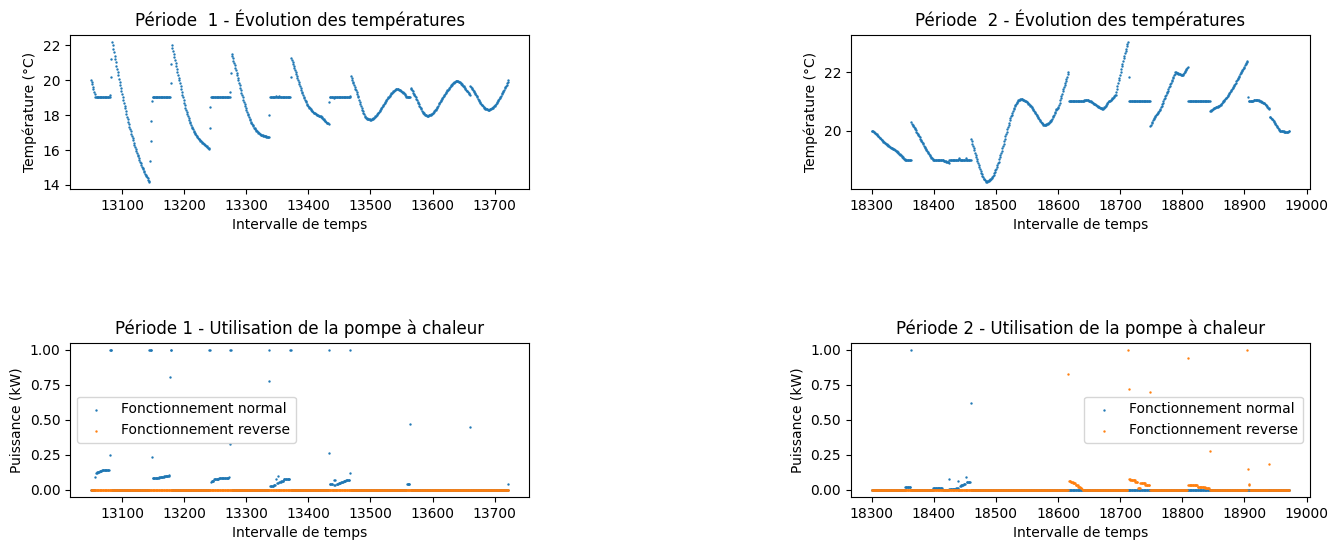

In [157]:
# Tache 2, période 1:
output_2_ref = basic(ref_week_start_idx, output_1_ref[3]*task_2_budget_coefficient)
print("Computed output_2_arbitrary in {time}s".format(time=output_2_ref[-1]))

# Tache 2, période 2:
output_2_arbitrary = basic(arbitrary_week_start_idx, output_1_arbitrary[3]*task_2_budget_coefficient)
print("Computed output_2_arbitrary in {time}s".format(time=output_2_arbitrary[-1]))

# Plot les résultats
plot_2(output_2_ref, output_2_arbitrary, ref_week_start_idx, arbitrary_week_start_idx)

On remplace à présent la notion d'inconfort décrite ci-dessus par une pénalisation quadratique : à présent l'inconfort  est proportionnel au *carré* du dépassement de la température maximale admissible, ou au *carré* du dépassement par le bas de la température minimale admissible (les coefficients de proportionnalité restent identiques).

<div class="alert alert-block alert-info"><b>Question 2.3</b> :<br> 
    Modélisez ce nouveau problème de façon linéaire, en utilisant une approximation. Cette approximation pourra par exemple être basée sur des tangentes  (choisissez un nombre pas trop élevé, par exemple 5). Expliquez votre technique de modélisation. Résolvez ce modèle approché, affichez les solutions et commentez (en particulier l'effet sur la solution par rapport au modèle d'inconfort initial).
</div>

<div class="alert alert-block alert-info"><b>Question 2.4</b> :<br> 
    Pour terminez cette partie, résolvez encore une fois ce nouveau modèle, mais cette fois de façon exacte, en utilisant un solveur quadratique. Comparez avec la solution approchée obtenue précédemment (allure de la solution, temps de calcul).
</div>

**Tâche 3** : on voudrait à présent mieux comprendre le compromis qui existe entre le budget alloué et l'inconfort total qui en résulte. Proposez un **graphique représentant au mieux cette relation entre budget et inconfort**, où on fera varier le budget entre entre zéro et le coût minimal identifié lors de la tâche 1 (ce budget sera indiqué en pourcentage, de 0 à 100%). Ceci nécessitera la résolution de plusieurs problèmes, et il sera judicieux d'utiliser la fonctionnalité _warm start_ du solver pour accélérer les calculs.

<div class="alert alert-block alert-warning"><b>A mentionner</b> :<br> 
- graphique demandé + temps de calcul (total et moyenne par problème) + bref commentaire (maximum 4 lignes)<br>
- à nouveau pour les deux périodes mentionnées  lors des tâches 1 et 2
</div>

---

<div class="alert alert-block alert-info"><b>Question 3.1</b> :<br> 
    Fournissez le graphique et les commentaires demandé ci-dessus
</div>

In [158]:
# Fonction qui effectue la tache 3
def task3(first_interval_idx, max_cost):
    last_interval_idx = first_interval_idx + computing_intervals_amount
    outputs = []
    max_allocated_budget = np.linspace(0, max_cost, num=100//task_3_step+1) 
    for i in range(len(max_allocated_budget)):
        output = basic(first_interval_idx, max_allocated_budget[i]) # Effectue la tache 2 en changeant le budget par la boucle for
        outputs.append(output)
    return outputs

Fonction qui plot pour la tache 3:

In [159]:
# Fonction qui plot la tache 3
def plot_3(period_1, period_2, period_1_first_interval_idx, period_2_first_interval_idx):
    periods = [period_1, period_2]
    first_interval_idxs = [period_1_first_interval_idx, period_2_first_interval_idx]

    # Crée la figure
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))

    # Plot les graphes pour les 2 périodes
    for i in range(len(periods)):
        period = periods[i]
        first_interval_idx = first_interval_idxs[i]
        last_interval_idx = first_interval_idx + computing_intervals_amount

        time = np.linspace(first_interval_idx, last_interval_idx, computing_intervals_amount)
        budget = [o for o in range(0,101,2)]
        inconfort = [o[4] if len(o) != 0 else math.inf for o in period]

        # Titres et légendes des plots des températures par 20%
        axs[0][i].set_title("Période {i} - Évolution des températures par 20%".format(i=i+1))
        axs[0][i].set_xlabel("Intervalle de temps")
        axs[0][i].set_ylabel("Température (°C)")

        # Titres et légendes des plots des températures par 10%
        axs[1][i].set_title("Période {i} - Évolution des températures par 10%".format(i=i+1))
        axs[1][i].set_xlabel("Intervalle de temps")
        axs[1][i].set_ylabel("Température (°C)")

        # Titres et légendes du plot des inconforts
        axs[2][i].set_title("Période {i} - Évolution des inconforts".format(i=i+1))
        axs[2][i].set_xlabel("Budget alloué (%)")
        axs[2][i].set_ylabel("Inconfort")

        for o in range(0,len(period),10):
            output = period[o]
            if len(output) == 0:
                continue
            
            # Plot des températures par 20%
            axs[0][i].scatter(time, output[0], label="{percent}%".format(percent=o*task_3_step), s=0.5)
            axs[0][i].legend(loc='center left', bbox_to_anchor=(1,0.5))
            plt. gcf(). subplots_adjust( wspace = 0.7, hspace = 1)

        for o in range(0,len(period),5):
            output = period[o]
            if len(output) == 0:
                continue

            # Plot des températures par 10%
            axs[1][i].scatter(time, output[0], label="{percent}%".format(percent=o*task_3_step), s=0.5)
            axs[1][i].legend(loc='center left', bbox_to_anchor=(1,0.5))
            plt. gcf(). subplots_adjust( wspace = 0.7, hspace = 1)

        # Plot des inconforts
        axs[2][i].scatter(budget, inconfort, color='red', s=5)

    fig.canvas.manager.set_window_title("Tâche 3 - Minimisation de l'inconfort avec budget restreint à {step}n%".format(step=task_3_step))
    plt.show()

Résultat de la tache 3:

Computed output_3_ref in 5.187273979187012s
Average time for output_3_ref: 0.1017137041278914s
Computed output_3_arbitrary in 4.5265116691589355s
Average time for output_3_arbitrary: 0.08875715498830758s


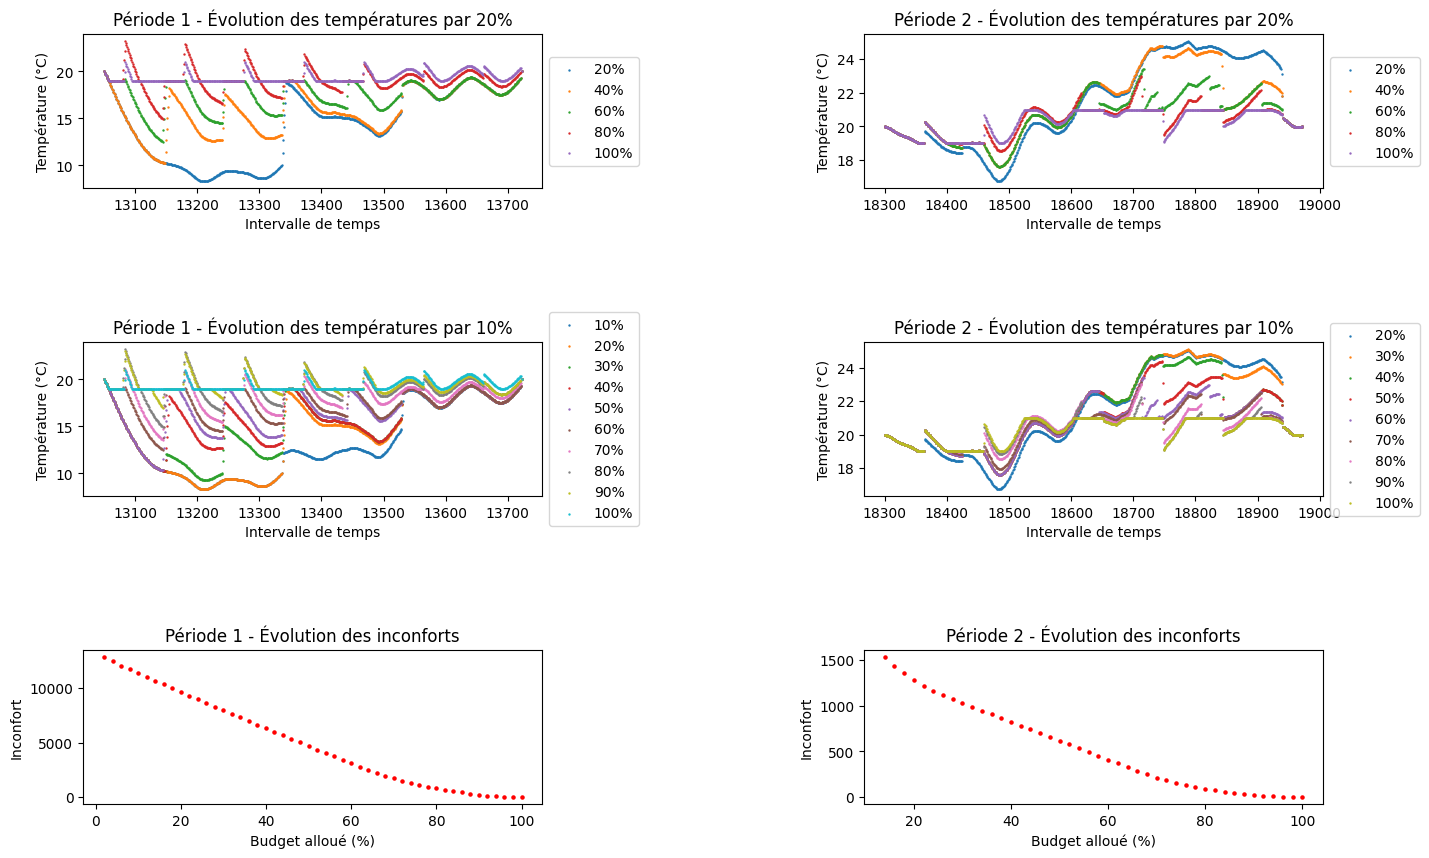

In [160]:
# Tache 3, période 1:
start = time.time()
output_3_ref = task3(ref_week_start_idx, output_1_ref[3])
print("Computed output_3_ref in {time}s".format(time=time.time()-start))
print("Average time for output_3_ref: {time}s".format(time=(time.time()-start)/51))

# Tache 3, période 2:
start = time.time()
output_3_arbitrary = task3(arbitrary_week_start_idx, output_1_arbitrary[3])
print("Computed output_3_arbitrary in {time}s".format(time=time.time()-start))
print("Average time for output_3_arbitrary: {time}s".format(time=(time.time()-start)/51))

# Plot les résultats
plot_3(output_3_ref, output_3_arbitrary, ref_week_start_idx, arbitrary_week_start_idx)

<div class="alert alert-block alert-info"><b>Question 3.2</b> :<br> 
    Expliquez la pente linéaire observée dans une grande partie du graphique obtenu. Recalculez la valeur de la pente à partir des informations fournies par le solver pour la résolution avec le budget maximal (tâche 2 initiale, Question 2.2), et comparez à celle du graphique. Enfin, expliquez pourquoi le graphique cesse à un moment d'être une droite.
</div>

---


<div class="alert alert-block alert-info"><b>Bonus</b><br>
    Estimez l'effet de l'utilisation d'une version imprécise des données de température (prévisions)<br>
</div>
Ce bonus est optionnel, et ne conduit pas à l'obtention de points supplémentaires : il est seulement destiné à attirer votre
    attention sur le caractère artificiel de la situation proposée, où on connaît parfaitement et à l'avance les températures extérieures.

## Consignes et conseils
- Le projet se réalise par groupe de (maximum) quatre étudiants (cf. groupes constitués sur Moodle). 

- L'assistant responsable du projet est Guillaume Van Dessel. Toutes les  questions sur le projet doivent être posées via Moodle dans le forum prévu pour le projet (et pas par message/mail individuel). Des permanences seront prévues, et seront annoncées via Moodle.

- Il est fortement suggéré d'utiliser un langage de modélisation pour formuler et résoudre vos problèmes d'optimisation linéaire. Nous conseillons d'utiliser le module CVXPY combiné au solver d'optimisation HIGHS (nous avons vérifié que cette combinaison est suffisamment performance pour le projet).

- Les groupes peuvent échanger leurs réflexions, partager leurs idées et comparer leurs résultats. Ils ne peuvent pas recopier les raisonnements, les solutions ou les codes informatiques. L'utilisation de toute information ou aide extérieure doit obligatoirement être mentionnée dans le rapport, en citant la source.

- Votre rapport final sera constitué de ce notebook complété, où vous aurez inséré vos codes, vos résultats, vos graphiques et commentaires.

- Ce rapport  est à remettre au plus tard le **mercredi 24 mai 2023** à minuit (soir), via Moodle, sous la forme d'une archive compressée contenant votre notebook et tous les fichiers nécessaires pour le faire fonctionner (code Python, etc.). Le notebook doit contenir les cellules sous forme déjà évaluée (résultats, tableaux, graphiques, etc.), mais doit pouvoir également être ré-évalué en entier. 

- Organisez efficacement votre travail de groupe, et répartissez vous le travail. Les tâches à effectuer durant cette seconde partie sont *largement indépendantes* les unes des autres.


### Changelog
- 2023-03-24 v1
- 2023-04-23 v1.1 avec récapitulatif des précisions apportées sur Moodle (en bleu)
- 2023-04-28 description des tâches de la seconde partie
- 2023-05-12 v2 avec le format attendu (notebook) pour le rapport final
- 2023-05-12 v2.1 précisions supplémentaire pour quelques questions